<h2 align="center">Predict Employee Churn with Decision Trees and Random Forests</h2>

In [29]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


### Task 1: Import Libraries
---

In [32]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [33]:
plt.rcParams['figure.figsize'] = (12,8)

### Task 2: Exploratory Data Analysis
---

In [34]:
hr = pd.read_csv('data/employee_data.csv')

In [35]:
hr.profile_report(title="Employee Data")

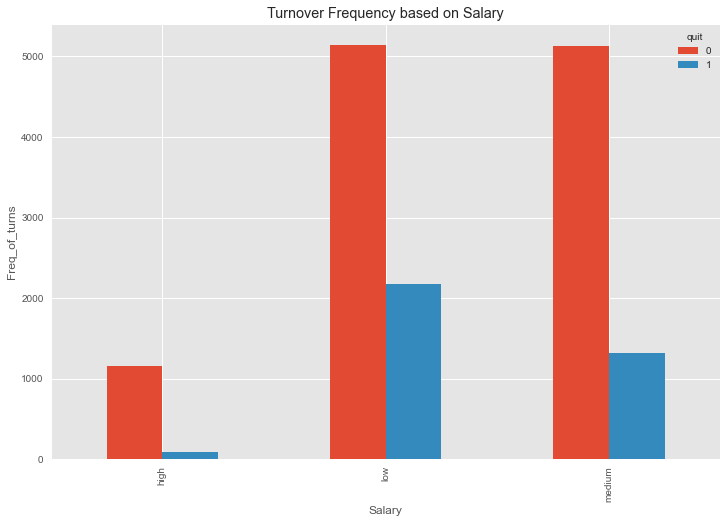

In [36]:
pd.crosstab(hr.salary, hr.quit).plot(kind='bar')
plt.title("Turnover Frequency based on Salary")
plt.xlabel("Salary")
plt.ylabel("Freq_of_turns")
plt.show()
#Much less frequency of turnover at higher salary

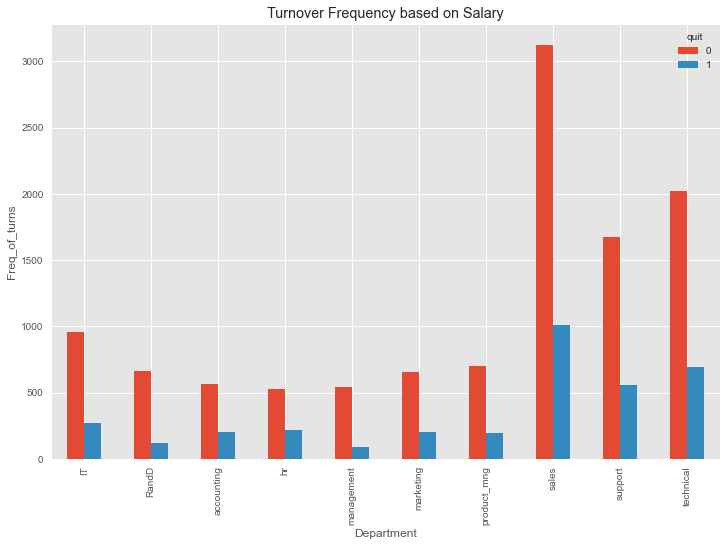

In [37]:
pd.crosstab(hr.department, hr.quit).plot(kind='bar')
plt.title("Turnover Frequency based on Salary")
plt.xlabel("Department")
plt.ylabel("Freq_of_turns")
plt.show()

In [38]:
# Finished with EDA
# We identified 2 categorical features 1. salary, 2. department
# One thing we have to overcome is that these are categorical variables
# They are in the string and object format, skitlearn can't take this type of data
# we will need to convert them into a format that will allow us to analyse them
# Such as decision tree classifiers/random forest classifiers
# We will use dummy, or one hot encoding next

### Task 3: Encode Categorical Features
---

In [39]:
# Explaing dummy encoding and go over the fact we will have 10 columns
# We will lose the labels
# we can attach a prefix to the names of the departments

In [40]:
cat_vars = ['department','salary']
for var in cat_vars:
    cat_list = pd.get_dummies(hr[var], prefix=var)
    hr=hr.join(cat_list)

In [41]:
cat_vars

['department', 'salary']

In [42]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0


In [43]:
hr.drop(columns=['department','salary'], axis=1, inplace=True)

In [44]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department_IT,department_RandD,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


### Task 4: Visualize Class Imbalance
---

In [45]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

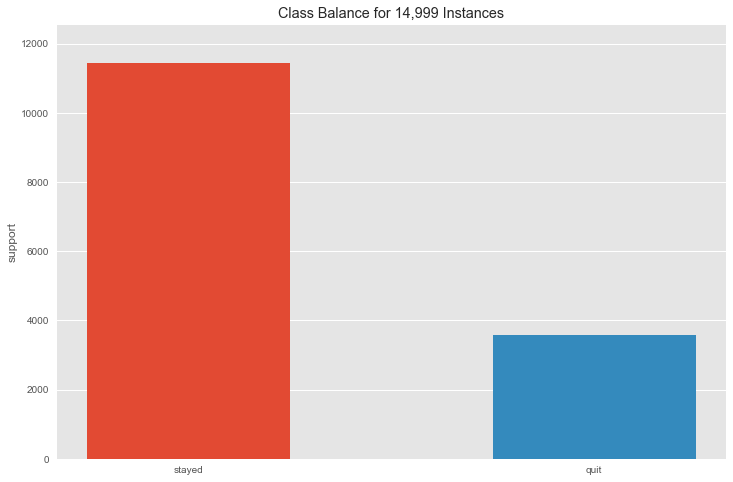

In [46]:
visualizer = ClassBalance(labels=['stayed','quit']).fit(hr.quit)
visualizer.show()

### Task 5: Create Training and Test Sets
---

In [47]:
X = hr.loc[:, hr.columns != 'quit']
y = hr.quit

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

### Task 6 & 7: Build an Interactive Decision Tree Classifier
---

Supervised learning: 
- The inputs are random variables $X = X_1, ..., X_p$;
- The output is a random variable $Y.$

- Data is a finite set $$\mathbb{L}=\{(x_i,y_i)|i=0, ..., N-1\}$$
where $x_i \in X = X_1 \times ... \times X_p$ and $y_i \in y$ are randomly drawn from $P_{X,Y}.$

E.g., $(x_i,y_i)=((\text{salary = low, department = sales, ...}),\text{quit = 1})$

- The goal is to find a model $\varphi_\mathbb{L}: X \mapsto y$ minimizing $$\text{Err}(\varphi_\mathbb{L}) = \mathbb{E}_{X,Y}\{L(Y, \varphi_\mathbb{L}(X))\}.$$

About:
 
 - Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any a priori assumption
 
- Decision trees handle numeric and categorical variables

- They implement feature selection, making them robust to noisy features (to an extent)

- Robust to outliers or errors in labels

- Easily interpretable by even non-ML practioners.

#### Decision trees: partitioning the feature space:

![partition](assets/partition-feature-space.png)

- Decision trees generally have low bias but have high variance.
- We will solve the high variance problem in Task 8.

In [49]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

Gini index and entropy are the criteria for calculating information gain. Decision tree algorithms use information gain to split a node. Both gini and entropy are measures of impurity of a node. A node having multiple classes is impure whereas a node having only one class is pure.

Splitting: It is a process of dividing a node into two or more sub-nodes. Decision Node: When a sub-node splits into further sub-nodes, then it is called decision node. Leaf/Terminal Node: Nodes do not split is called Leaf or Terminal node.

In [50]:
@interact
def plot_tree(crit=['gini','entropy'],
              split=['best','random'],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=1,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    estimator = DecisionTreeClassifier(random_state=0,
                                      criterion=crit,
                                      splitter=split,
                                      max_depth=depth,
                                      min_samples_split=min_split,
                                      min_samples_leaf=min_leaf)
    estimator.fit(X_train, y_train)
    print('Decision Tree Training Acc:{:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Decision Tree Test Acc:{:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
    
    
    graph = Source(tree.export_graphviz(estimator,out_file=None,
                                       feature_names=X_train.columns,
                                       class_names=['stayed', 'quit'],
                                       filled=True))
    
    display(Image(data=graph.pipe(format='png')))
    
    #do later
    return estimator 

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Task 8: Build an Interactive Random Forest Classifier
---

Although randomization increases bias, it is possible to get a reduction in variance of the ensemble. Random forests are one of the most robust machine learning algorithms for a variety of problems.

- Randomization and averaging lead to a reduction in variance and improve accuracy
- The implementations are parallelizable
- Memory consumption and training time can be reduced by bootstrapping
- Sampling features and not solely sampling examples is crucial to improving accuracy

In [51]:
@interact
def plot_tree_rf(crit=['gini','entropy'],
                 bootstrap=['True','False'],
                 depth=IntSlider(min=1,max=7,value=2, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    estimator = RandomForestClassifier(random_state=0,
                                       criterion=crit,
                                       bootstrap=bootstrap,
                                       max_depth=depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf,
                                       n_jobs=1,
                                       verbose=False).fit(X_train, y_train)
    
    estimator.fit(X_train, y_train)

    print('Random Forest Training Acc:{:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Random Forest Test Acc:{:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
    num_tree=estimator.estimators_[5]
    print('Visualizing Tree:', 0)
    
    graph = Source(tree.export_graphviz(num_tree,
                                        out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['stayed', 'quit'],
                                        filled=True))
    
    display(Image(data=graph.pipe(format='png')))
    
        #do later
    return estimator 
   

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Task 9: Feature Importance and Evaluation Metrics
---

In [52]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

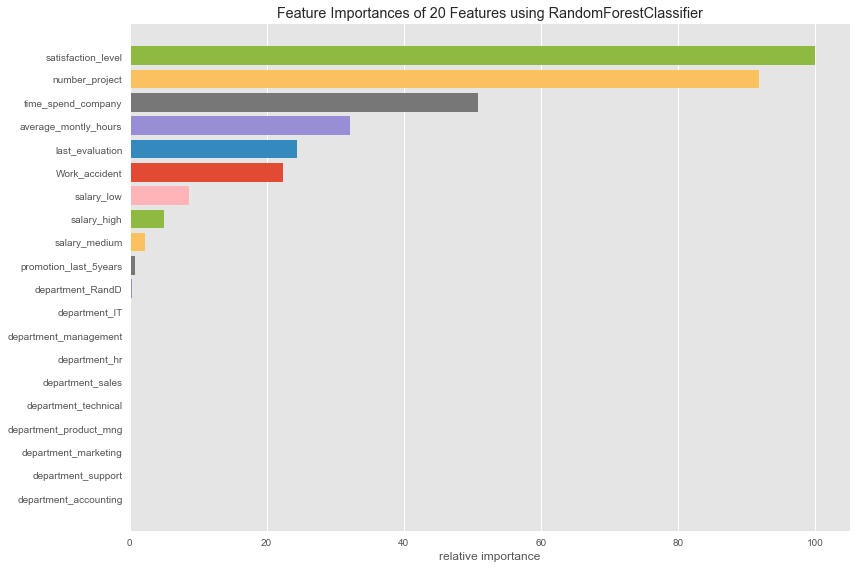

In [53]:
rf = RandomForestClassifier(bootstrap='True', 
                            max_depth=2, 
                            n_jobs=1, 
                            random_state=0,
                            verbose=False)
viz = FeatureImportances(rf)
viz.fit(X_train, y_train)
viz.show();

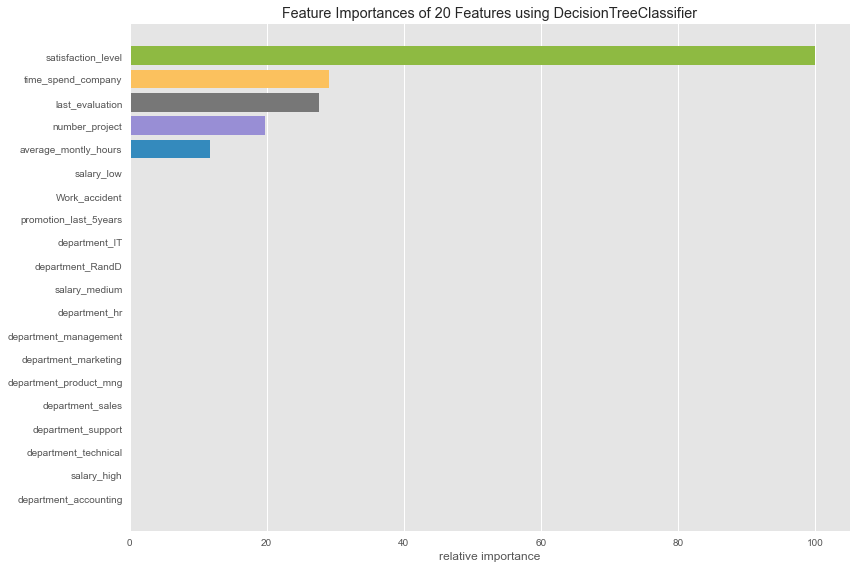

In [54]:
dt = DecisionTreeClassifier(max_depth=5, random_state=0)
viz = FeatureImportances(dt)
viz.fit(X_train, y_train)
viz.show()